In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
import imageio
import numpy as np
import cv2

from tqdm import tqdm

from albumentations.pytorch import ToTensorV2
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

In [234]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [235]:
class CatVsDog_2class(Dataset):
    def __init__(self, path_dir1:str, path_dir2:str, transform=None):
        super().__init__()
        self.transform = transform
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
    
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
        
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = imageio.v2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.0
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            t_img = transformed["image"]
        t_class_id = torch.tensor(class_id)
        
        return t_img, t_class_id

In [236]:
train_dogs_path = 'C:\\Users\\качёк\\Desktop\\ЮТУБ\\ДНЕВНИК DL\\ResNet\\data\\dataset\\training_set\\dogs'
train_cats_path = 'C:\\Users\\качёк\\Desktop\\ЮТУБ\\ДНЕВНИК DL\\ResNet\\data\\dataset\\training_set\\cats'

transform_train = A.Compose(
    [
        A.Resize(224, 224),
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

train_ds_catsdogs = CatVsDog_2class(train_dogs_path, train_cats_path, transform=transform_train)

In [237]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, 
    batch_size=batch_size, drop_last=True
)

(tensor([[[0.2632, 0.2162, 0.1835,  ..., 0.3827, 0.3810, 0.3775],
         [0.2660, 0.2347, 0.2189,  ..., 0.3816, 0.3807, 0.3772],
         [0.2377, 0.2154, 0.2126,  ..., 0.3710, 0.3684, 0.3667],
         ...,
         [0.8340, 0.8541, 0.8756,  ..., 0.3137, 0.3090, 0.3042],
         [0.8163, 0.8351, 0.8582,  ..., 0.3207, 0.3185, 0.3164],
         [0.7957, 0.8134, 0.8377,  ..., 0.3216, 0.3239, 0.3249]],

        [[0.4756, 0.4358, 0.4058,  ..., 0.4729, 0.4712, 0.4677],
         [0.4728, 0.4459, 0.4337,  ..., 0.4718, 0.4709, 0.4674],
         [0.4349, 0.4164, 0.4204,  ..., 0.4612, 0.4586, 0.4569],
         ...,
         [0.7909, 0.8109, 0.8325,  ..., 0.3607, 0.3560, 0.3513],
         [0.7732, 0.7920, 0.8150,  ..., 0.3677, 0.3656, 0.3634],
         [0.7526, 0.7703, 0.7946,  ..., 0.3686, 0.3710, 0.3720]],

        [[0.5666, 0.5352, 0.5179,  ..., 0.5336, 0.5339, 0.5304],
         [0.5690, 0.5504, 0.5501,  ..., 0.5326, 0.5337, 0.5302],
         [0.5429, 0.5279, 0.5430,  ..., 0.5220, 0.5214, 0

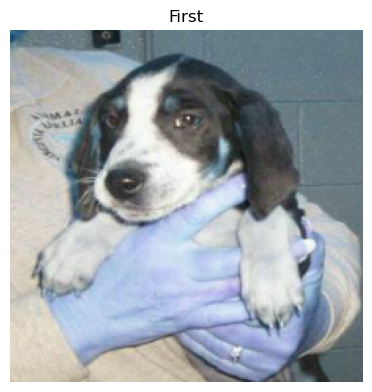

In [238]:
import matplotlib.pyplot as plt

data = train_ds_catsdogs
id = 1

fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
plt.imshow(np.transpose(data[id][0], (1,2,0)))
plt.axis('off')
plt.title("First")

print(data[id])

In [239]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super(ResBlock, self).__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.conv1(out)
        
        return self.act(x + out)

In [240]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks):
        super(ResTruck, self).__init__()
        
        truck = []
        for i in range(num_blocks):
            truck += [ResBlock(nc)]
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):        
        return self.truck(x)

In [241]:
class ResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super(ResNet, self).__init__()
        
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.layer1 = ResTruck(nc, 3)
        self.conv1 = nn.Conv2d(nc, 2*nc, kernel_size=3, padding=1, stride=2)
        self.layer2 = ResTruck(2*nc, 4)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, kernel_size=3, padding=1, stride=2)
        self.layer3 = ResTruck(4*nc, 6)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, kernel_size=3, padding=1, stride=2)
        self.layer4 = ResTruck(4*nc, 3)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

In [249]:
model = ResNet(3, 32, 2)

In [250]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [251]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [252]:
device = 'cuda' # if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = loss_fn.to(device)

In [253]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()

In [254]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [255]:
epochs = 20
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample
        label = F.one_hot(label, 2).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(epoch+1)
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\качёк\AppData\Local\Temp\ipykernel_9708\156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.70026	accuracy: 0.562: 100%|█████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.98it/s]


1
0.7041264209747314
0.519625


loss: 0.70068	accuracy: 0.500: 100%|█████████████████████████████████████████████████| 500/500 [01:50<00:00,  4.54it/s]


2
0.6926689453125
0.522375


loss: 0.73788	accuracy: 0.375: 100%|█████████████████████████████████████████████████| 500/500 [01:45<00:00,  4.76it/s]


3
0.6819673719406127
0.56775


loss: 0.58030	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [01:46<00:00,  4.68it/s]


4
0.6616959381103515
0.606625


loss: 0.83824	accuracy: 0.438: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


5
0.6461837425231933
0.62025


loss: 0.71426	accuracy: 0.625: 100%|█████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.97it/s]


6
0.6381282730102539
0.6355


loss: 0.51204	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [03:57<00:00,  2.11it/s]


7
0.6290555763244629
0.645


loss: 0.56625	accuracy: 0.812: 100%|█████████████████████████████████████████████████| 500/500 [03:52<00:00,  2.15it/s]


8
0.6222847862243652
0.653


loss: 0.79016	accuracy: 0.438: 100%|█████████████████████████████████████████████████| 500/500 [03:39<00:00,  2.28it/s]


9
0.6141414127349853
0.66275


loss: 0.68952	accuracy: 0.625: 100%|█████████████████████████████████████████████████| 500/500 [01:48<00:00,  4.60it/s]


10
0.6113174839019775
0.66275


loss: 0.67060	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [01:45<00:00,  4.75it/s]


11
0.6106010169982911
0.6665


loss: 0.62468	accuracy: 0.500: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.80it/s]


12
0.6053796730041504
0.666375


loss: 0.68811	accuracy: 0.562: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.80it/s]


13
0.6051067876815795
0.66975


loss: 0.60447	accuracy: 0.562: 100%|█████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.81it/s]


14
0.603619104385376
0.674625


loss: 0.47781	accuracy: 0.938: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.81it/s]


15
0.6009522562026978
0.67375


loss: 0.63146	accuracy: 0.625: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.80it/s]


16
0.6022870407104493
0.669125


loss: 0.58702	accuracy: 0.688: 100%|█████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.79it/s]


17
0.6025990200042725
0.671625


loss: 0.49305	accuracy: 0.812: 100%|█████████████████████████████████████████████████| 500/500 [01:49<00:00,  4.58it/s]


18
0.6014378480911254
0.671375


loss: 0.60229	accuracy: 0.625: 100%|█████████████████████████████████████████████████| 500/500 [01:48<00:00,  4.60it/s]


19
0.6037416105270386
0.672625


loss: 0.62431	accuracy: 0.750: 100%|█████████████████████████████████████████████████| 500/500 [02:37<00:00,  3.18it/s]

20
0.6039533376693725
0.6685
